In [1]:
from linear_regression import *

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", style="whitegrid", palette=sns.color_palette("muted", 2))

# 探索数据

In [3]:
# 获取数据集
data_url = "http://lib.stat.cmu.edu/datasets/boston"
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

boston = np.hstack([data, target.reshape(-1, 1)])
boston_df = pd.DataFrame(boston, columns=columns)

```
特征 说明
 CRIM      per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS     proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per 10,000
 PTRATIO   pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
 MEDV     Median value of owner-occupied homes in 1000's
 ```

In [4]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
boston_df.shape

(506, 14)

In [6]:
## 查重
boston_df.duplicated().sum()

0

In [7]:
miss = boston_df.isnull().sum(axis=0).sort_values(ascending = False)
miss

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

**没有缺失值**

# 特征分析

In [8]:
# 数值特征总览
data_describe = boston_df.describe()
data_describe

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


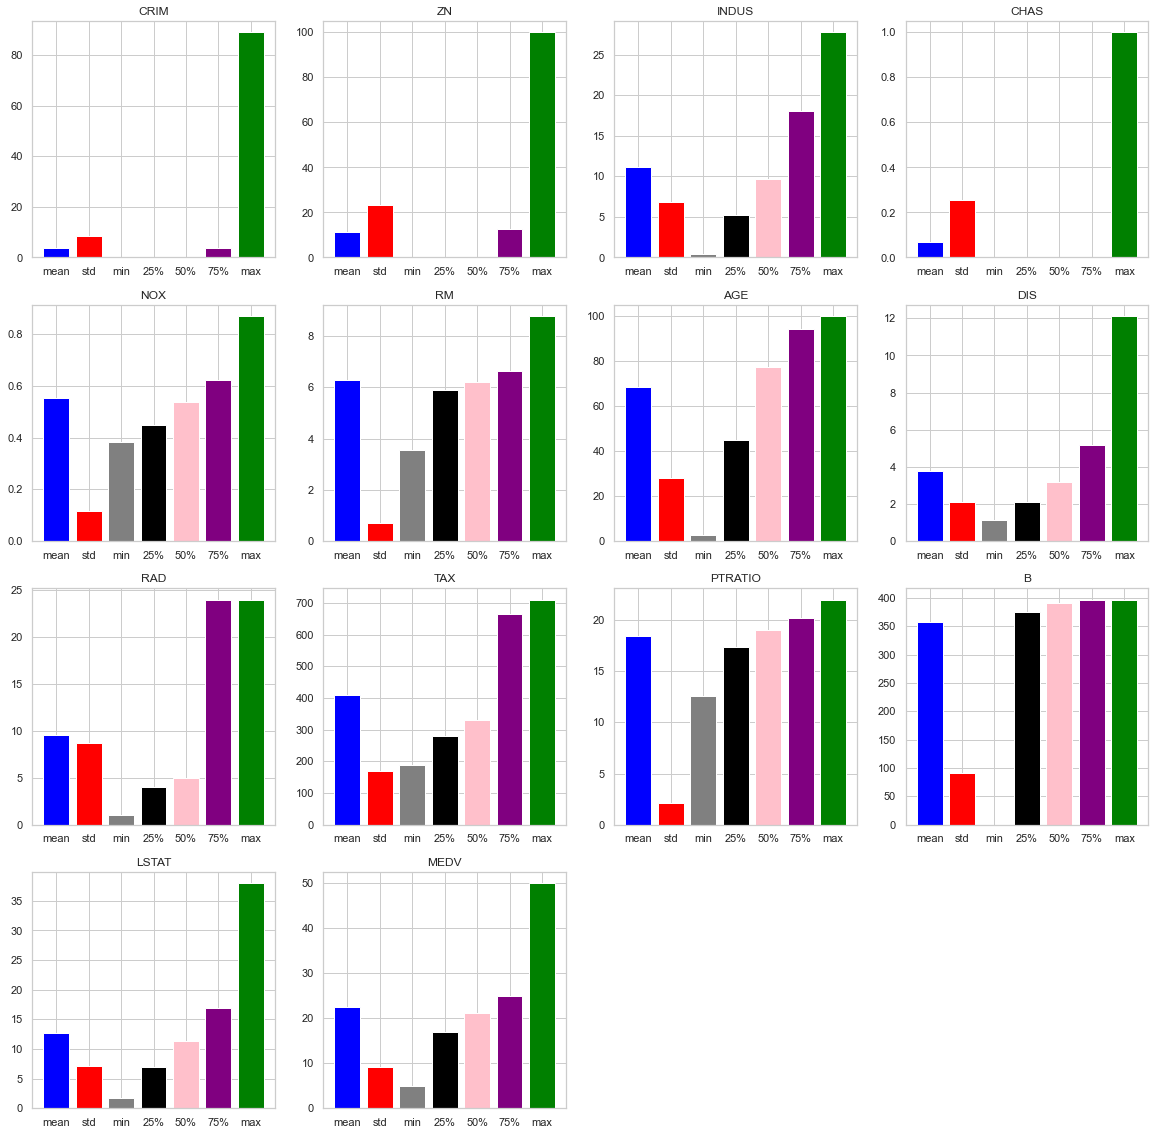

In [9]:
index = data_describe.index[1:]
colors = ['b','r','gray','black','pink','purple','g','y']
plt.figure(figsize=(20,20))
for i in range(len(columns)):
    ax = plt.subplot(4, 4, i+1)
    ax.set_title(columns[i])
    for j in range(len(index)):
        plt.bar(index[j], data_describe.loc[index[j], columns[i]], color=colors[j])
plt.show()

<AxesSubplot:>

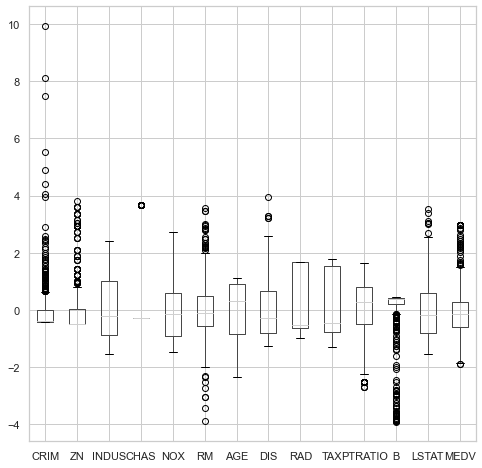

In [10]:
# 异常值分析
boston_df_new = (boston_df-boston_df.mean())/boston_df.std()
boston_df_new.boxplot(figsize=(8, 8))

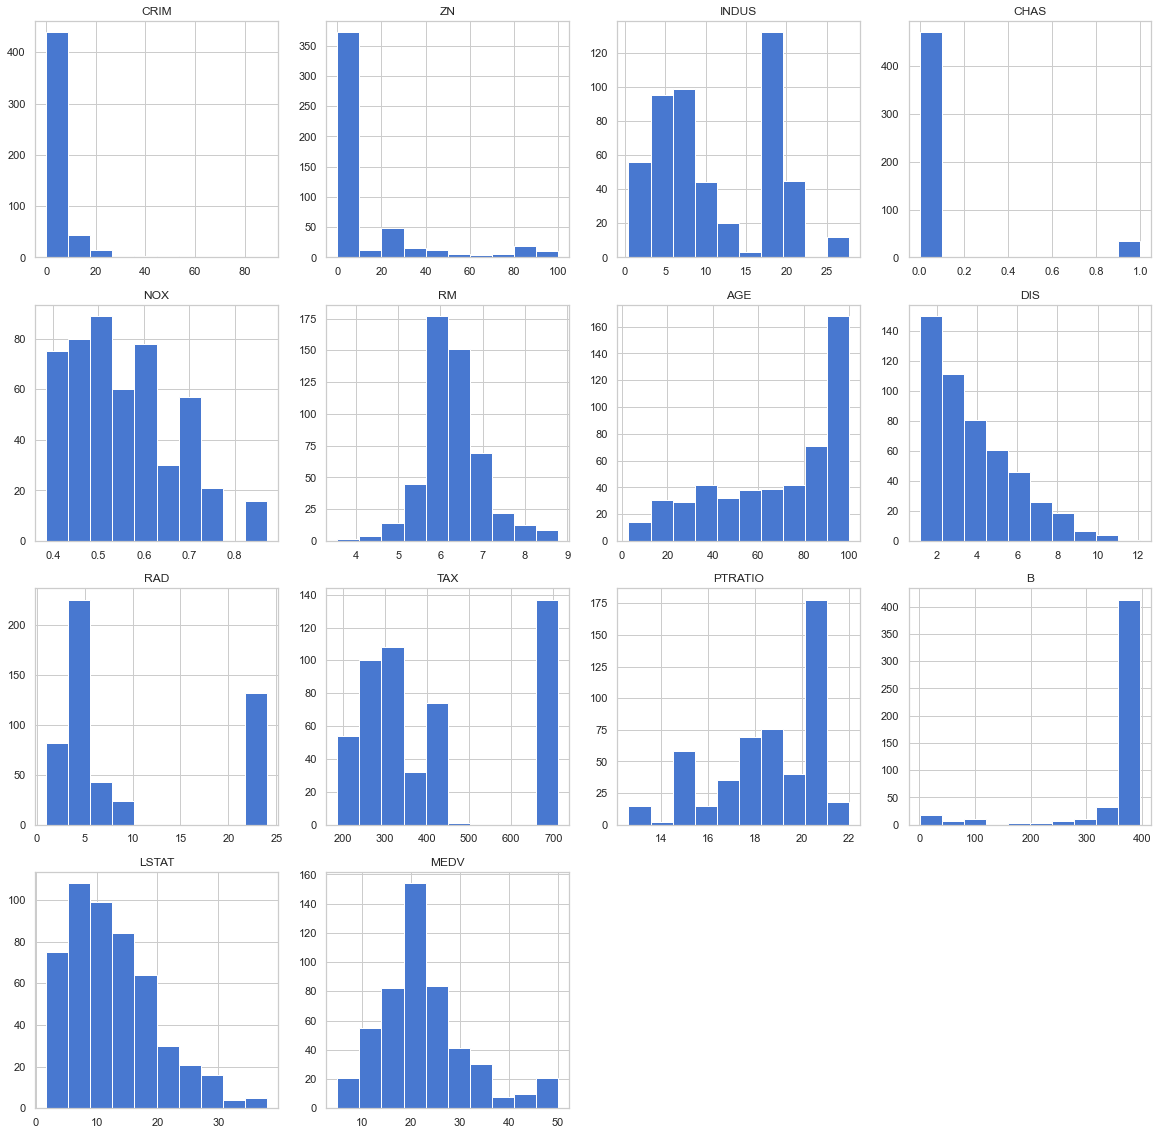

In [11]:
# 分布分析
plt.figure(figsize=(20, 20))
for i in range(len(columns)):
    ax = plt.subplot(4, 4, i+1)
    ax.set_title(columns[i])
    plt.hist(boston_df.iloc[:, i])
plt.show()

**'CRIM','ZN','CHAS','B'特征数据集中，方差较小，可考虑删除**

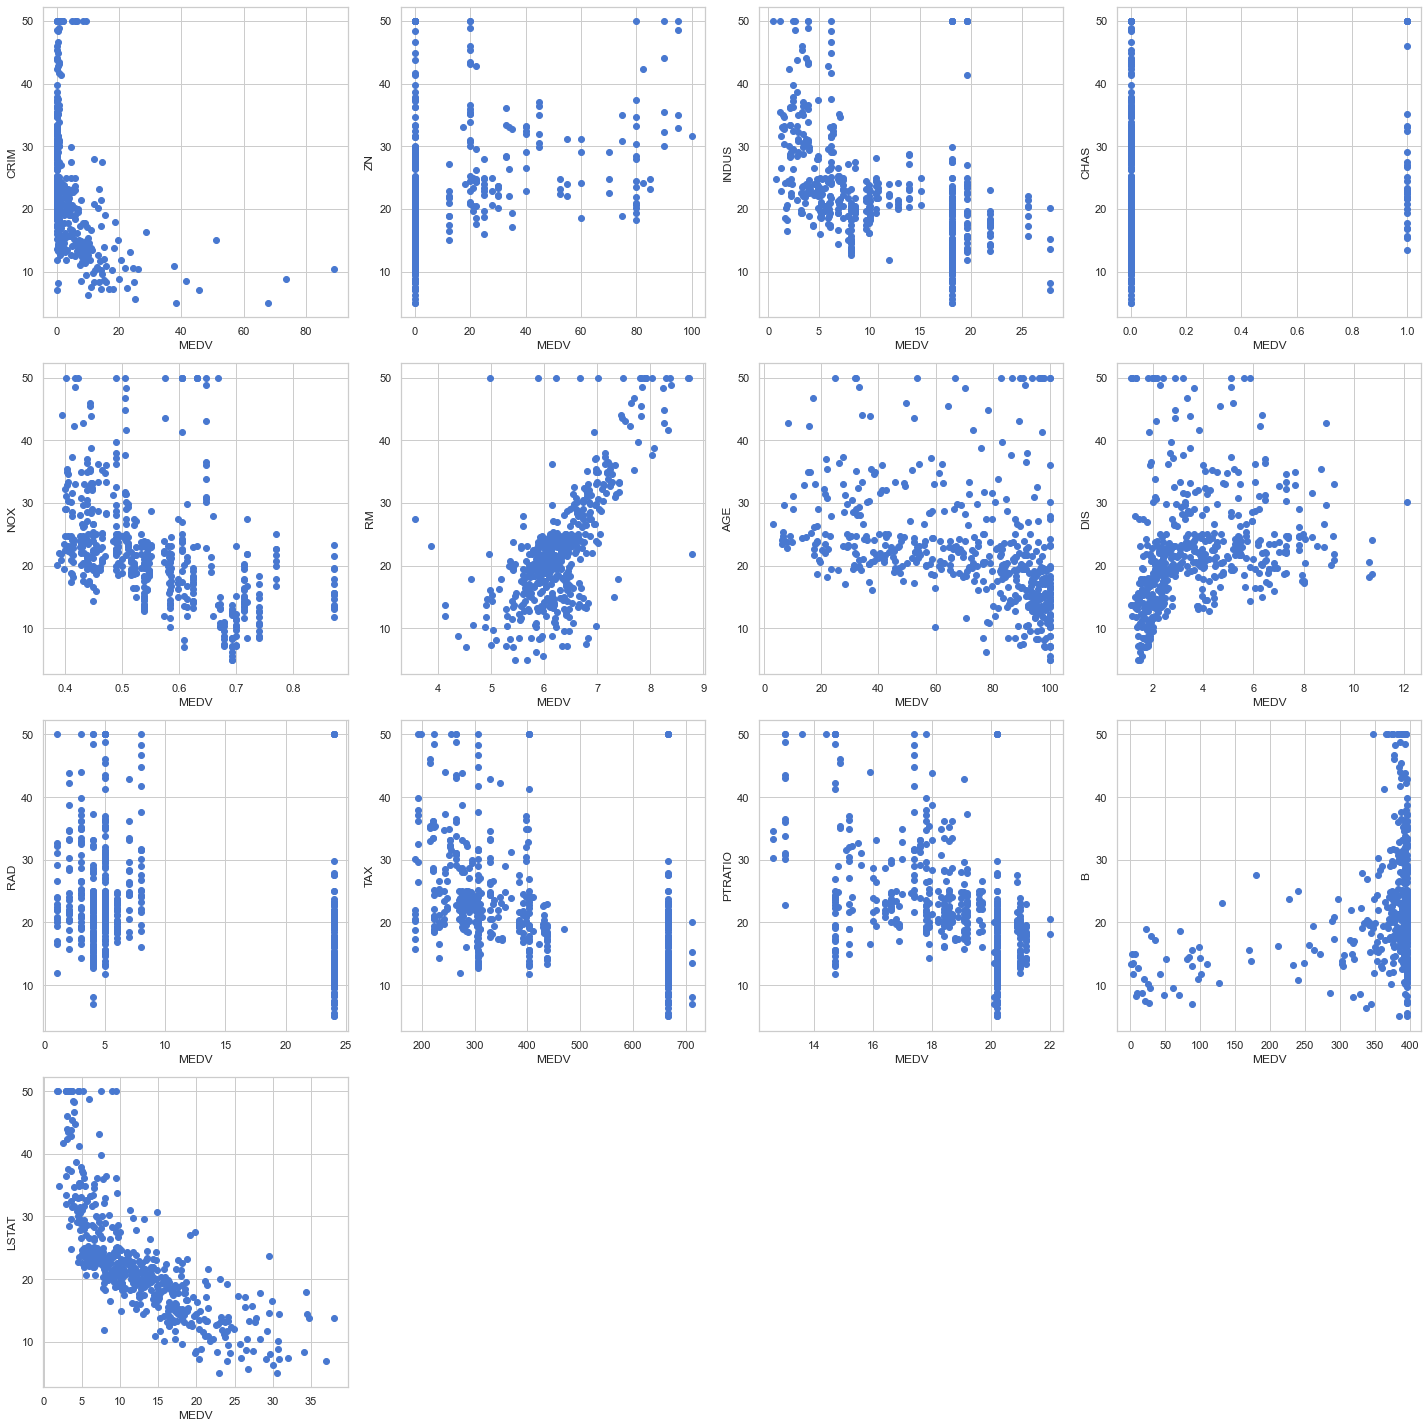

In [12]:
# 特征相关性可视化
plt.figure(figsize=(20, 20))
for i in range(len(columns[:-1])):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(boston_df.values[:, i], boston_df['MEDV'].values, "o")
    plt.xlabel('MEDV')
    plt.ylabel(columns[i])
plt.tight_layout()
plt.show()

**散点图看出'RM'与目标值成近似正相关，‘LSTAT’成近似负相关，其他特征看不出明显相关性**

<AxesSubplot:>

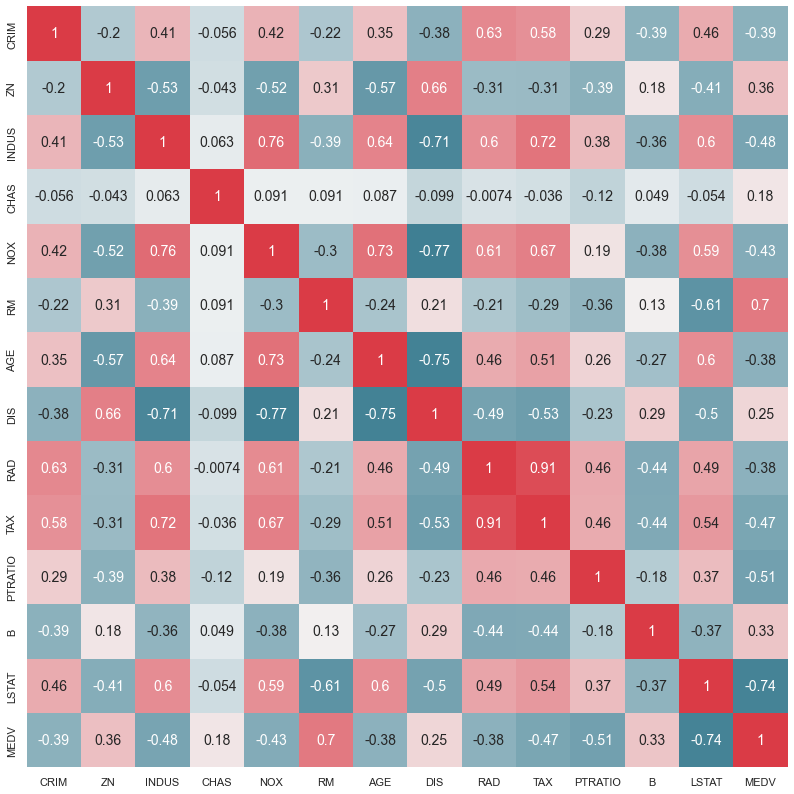

In [13]:
cmap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14, 14))
sns.heatmap(boston_df.corr(), cmap = cmap, square = True, cbar = False,  annot = True, annot_kws = {'fontsize':14})

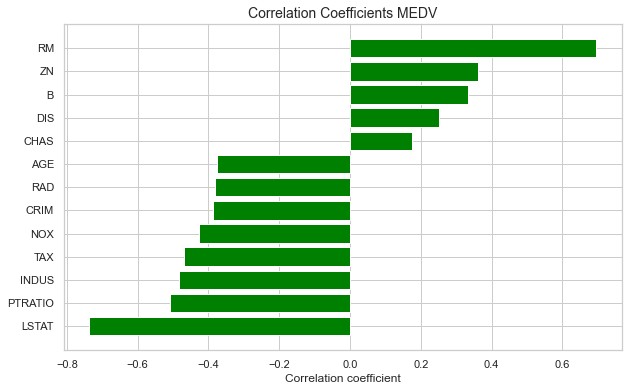

In [14]:
# MEDV最相关可视化
Survive_Corr = boston_df.corr()["MEDV"]
Survive_Corr = Survive_Corr[:-1]
Survive_Corr = Survive_Corr[np.argsort(Survive_Corr, axis = 0)] 
fig, ax = plt.subplots(figsize = (10,6))
ax.barh(np.arange(len(Survive_Corr)), np.array(Survive_Corr.values), color = 'g')
ax.set_yticks(np.arange(len(Survive_Corr)))
ax.set_yticklabels(Survive_Corr.index)
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients MEDV",fontsize = 14);
plt.show()

**看出'RM'和'LSTAT'两个特征值与目标值相关性较强**

# 数据预处理

In [15]:
# 去除低方差特征
transfor = VarianceThreshold(5)
data_new = transfor.fit_transform(data)

# PCA降维
transfor = PCA(0.99)
data_new = transfor.fit_transform(data_new)

# 标准化
data_new = (data_new-data_new.mean())/data_new.std()
target_new = (target- target.mean())/target.std()

In [16]:
# 分训练集和测试集（没定随机数种子，所以每次结果都会不太一样）
x_train, x_test, y_train, y_test = train_test_split(data_new, target_new)

# 训练过程

In [17]:
# 定义参数
lr = 1e-3

In [18]:
# 最小二乘法
model_1 = LinearRegression(x_train, y_train)
w1 = model_1.least_square()

最终损失为：0.69858373


In [19]:
# 梯度下降法
model_2 = LinearRegression(x_train, y_train)
w2 = model_2.grad_descent(lr)

第5次训练均方误差损失为1.29316363
第10次训练均方误差损失为0.83894754
第15次训练均方误差损失为0.73443411
第20次训练均方误差损失为0.70921694
第25次训练均方误差损失为0.70251038
第30次训练均方误差损失为0.70038241
第35次训练均方误差损失为0.69953397
第40次训练均方误差损失为0.69912264
第45次训练均方误差损失为0.69889871
第50次训练均方误差损失为0.69877003
第55次训练均方误差损失为0.69869443
第60次训练均方误差损失为0.69864962
第65次训练均方误差损失为0.69862297
第70次训练均方误差损失为0.69860711
第75次训练均方误差损失为0.69859766
第80次训练均方误差损失为0.69859203
第85次训练均方误差损失为0.69858867
第90次训练均方误差损失为0.69858667
第95次训练均方误差损失为0.69858548
第100次训练均方误差损失为0.69858477


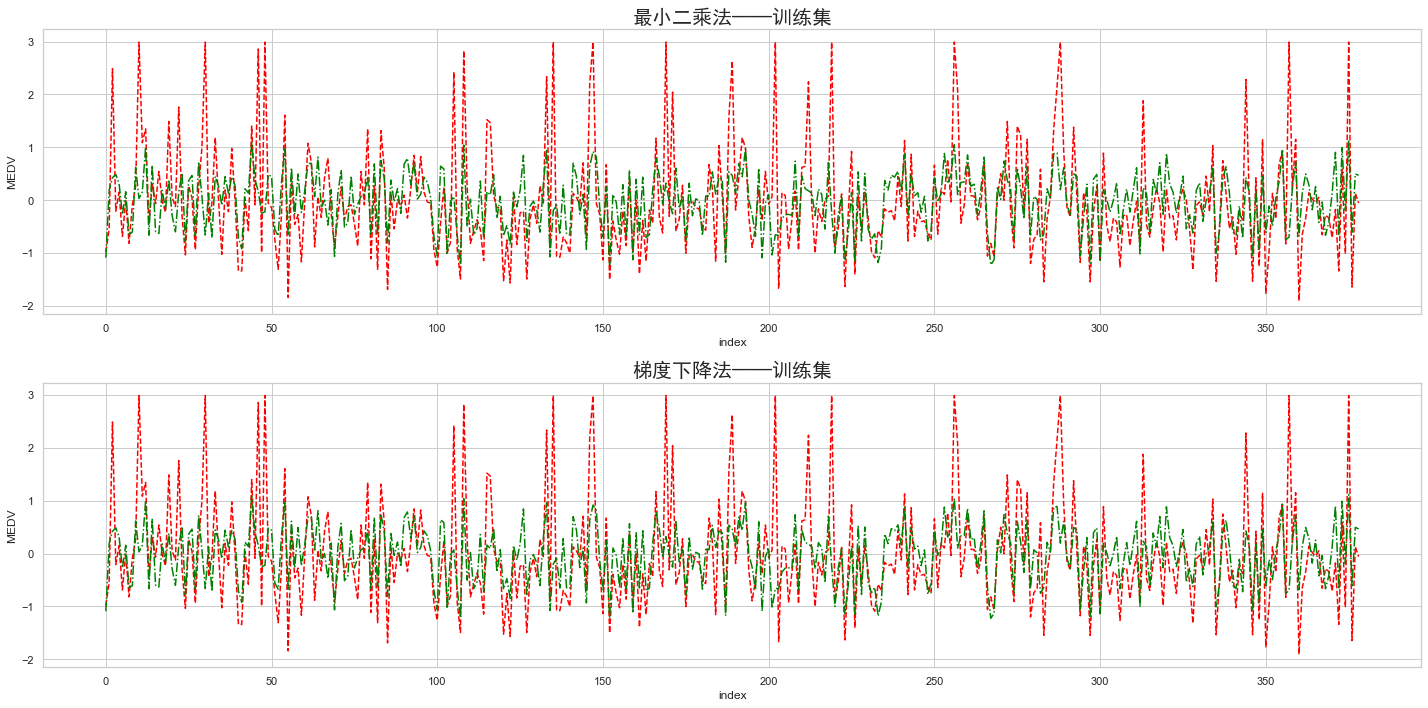

In [20]:
# 可视化
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 1, 1)
plt.title("最小二乘法——训练集", fontproperties="SimHei", fontsize=20)
plt.xlabel("index")
plt.ylabel("MEDV")
plt.plot(np.arange(0, x_train.shape[0]), y_train, 'r--')
plt.plot(np.arange(0, x_train.shape[0]), f(x_train, w1), 'g-.')

ax2 = plt.subplot(2, 1, 2)
plt.title("梯度下降法——训练集", fontproperties='SimHei', fontsize=20)
plt.xlabel("index")
plt.ylabel("MEDV")
plt.plot(np.arange(0, x_train.shape[0]), y_train, 'r--')
plt.plot(np.arange(0, x_train.shape[0]), f(x_train, w2), 'g-.')

plt.tight_layout()
plt.show()

# 验证过程

In [21]:
predict_1 = f(x_test, w1)
loss_1 = loss_fn(predict_1, y_test)
print("最小二乘法——测试集损失为{:.8f}".format(loss_1))

最小二乘法——测试集损失为0.75913675


In [22]:
predict_2 = f(x_test, w2)
loss_2 = loss_fn(predict_2, y_test)
print("梯度下降法——测试集损失为{:.8f}".format(loss_2))

梯度下降法——测试集损失为0.75888308


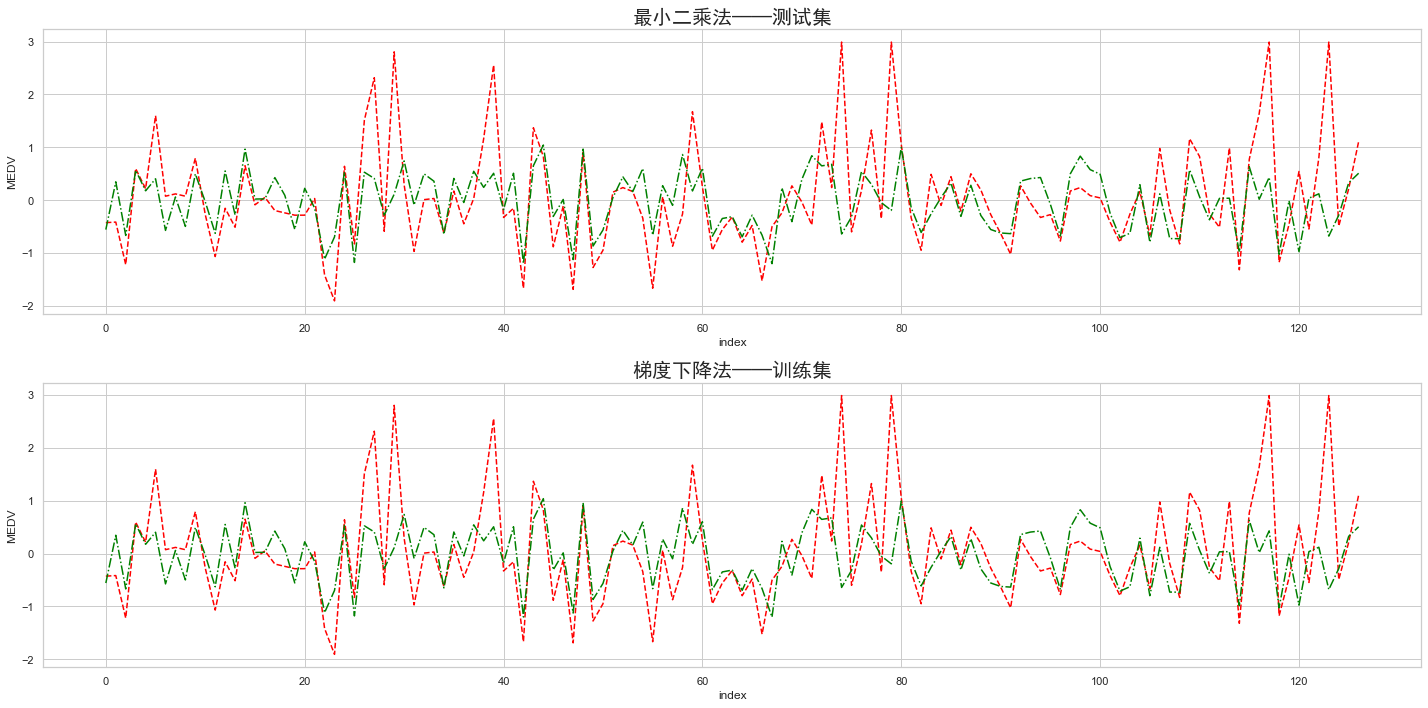

In [23]:
# 可视化
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 1, 1)
plt.title("最小二乘法——测试集", fontproperties='SimHei', fontsize=20)
plt.xlabel("index")
plt.ylabel("MEDV")
plt.plot(np.arange(0, x_test.shape[0]), y_test, 'r--')
plt.plot(np.arange(0, x_test.shape[0]), f(x_test, w1), 'g-.')

ax2 = plt.subplot(2, 1, 2)
plt.title("梯度下降法——训练集", fontproperties='SimHei', fontsize=20)
plt.xlabel("index")
plt.ylabel("MEDV")
plt.plot(np.arange(0, x_test.shape[0]), y_test, 'r--')
plt.plot(np.arange(0, x_test.shape[0]), f(x_test, w2), 'g-.')

plt.tight_layout()
plt.show()

# 保存模型

In [24]:
np.save("least_square.npy", w1)
np.save("grad_descent.npy", w2)